##### Зависимости и утильные функции:

In [7]:
from functools import partial
from itertools import zip_longest

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import cho_factor, cho_solve
from scipy.special import expit
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sympy import *

In [2]:
# Utils
def to_name(method):
    return method.__name__.replace('_', ' ').capitalize()

In [15]:
### 1. Реализуйте описанные методы одномерного поиска. Сравните их по количеству итераций и количеству вычислений функции в зависимости от разной точности. Для каждого метода обязательно указывайте, как изменяется отрезок при переходе к следующей итерации.

In [16]:
#### 1.1 Реализация методов одномерного поиска:

In [3]:
def straight(f):
    x_prev = np.random.uniform(low=begin, high=end)
    delta = 0.1

    if f(x_prev) > f(x_prev + delta):
        x_cur = x_prev + delta
        h = delta
        # elif f(x_prev) > f(x_prev - delta):
    else:
        x_cur = x_prev - delta
        h = -delta

    while True:
        h *= 2
        x_next = x_cur + h

        if f(x_cur) > f(x_next):
            x_prev = x_cur
            x_cur = x_next
        else:
            return x_prev, x_next

In [4]:
def one_dimensional(f, a0, b0, eps, max_iter_num, x1_f, x2_f):
    a = [a0]
    b = [b0]
    iter_num = 1
    while abs(f(b[-1]) - f(a[-1])) > eps and iter_num < max_iter_num:
        x1 = x1_f(a[-1], b[-1], iter_num)
        x2 = x2_f(a[-1], b[-1], iter_num)
        if f(x1) < f(x2):
            a.append(a[-1])
            b.append(x2)
        elif f(x1) > f(x2):
            a.append(x1)
            b.append(b[-1])
        else:
            break
        iter_num += 1
    return a, b, iter_num


def dichotomy(f, a0, b0, eps, max_iter_num):
    delta = eps / 3  # Should be less than eps / 2
    x1_f = lambda a, b, _: (a + b) / 2 - delta
    x2_f = lambda a, b, _: (a + b) / 2 + delta
    return one_dimensional(f, a0, b0, eps, max_iter_num, x1_f, x2_f)


def gold_section(*args):
    phi = (1 + np.sqrt(5)) / 2
    x1_f = lambda a, b, _: b - (b - a) / phi
    x2_f = lambda a, b, _: a + (b - a) / phi
    return one_dimensional(*args, x1_f, x2_f)


def fibonacci(f, a0, b0, eps, max_iter_num):
    fibs = [1, 1, 2]

    def add_fib():
        fibs.append(fibs[-1] + fibs[-2])

    n = 0
    while (b0 - a0) >= fibs[n + 2] * eps:
        n += 1
        add_fib()

    fib_np2 = fibs[n + 2]

    x1_f = lambda a, _, iter_num: a + (b0 - a0) * fibs[n - iter_num + 1] / fib_np2
    x2_f = lambda a, _, iter_num: a + (b0 - a0) * fibs[n - iter_num + 2] / fib_np2
    return one_dimensional(f, a0, b0, eps, max_iter_num, x1_f, x2_f)


one_dimensional_methods = [dichotomy, gold_section, fibonacci]

In [ ]:
#### 1.2 Тестируемая функция и действительное значение минимума:

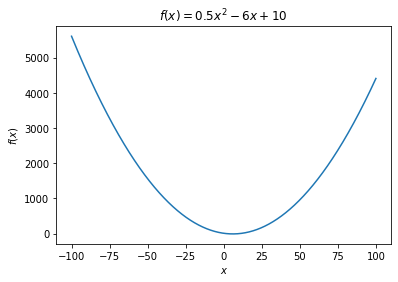

x_min = 5.990599059905989


In [8]:
def parabola(x):
    return 0.5 * x ** 2 - 6 * x + 10


begin = -100.0
end = 100.0

xs = np.linspace(begin, end, 10000)
ys = parabola(xs)
plt.plot(xs, ys)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title('$f(x) = 0.5x^2 - 6x + 10$')
plt.show()
print(f'x_min = {xs[ys.argmin()]}')

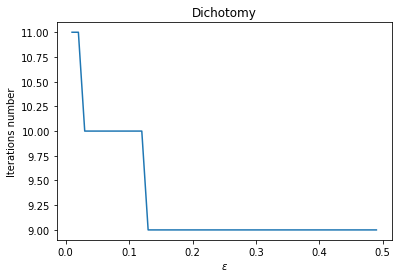

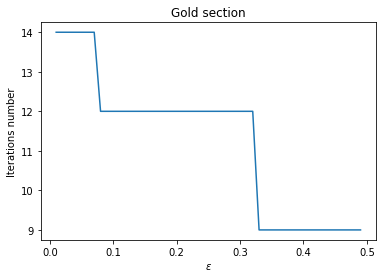

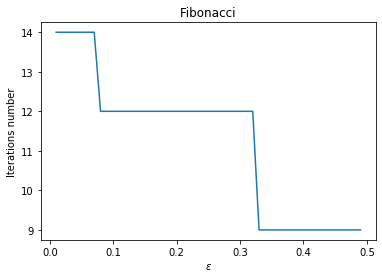

In [19]:
#### 1.3 Графики зависимости количества итераций от точности:
a0, b0 = begin, end
eps_range = np.arange(0.01, 0.5, 0.01)
max_iter_num = 100
for odm in one_dimensional_methods:
    iter_nums = []
    for eps in eps_range:
        _, _, iter_num = odm(parabola, a0, b0, eps, max_iter_num)
        iter_nums.append(iter_num)
    plt.plot(eps_range, iter_nums)
    plt.title(to_name(odm))
    plt.xlabel('$\epsilon$')
    plt.ylabel('Iterations number')
    plt.show()


#### 1.4 Графики интервалов по номеру итерации:

In [ ]:
a0, b0 = begin, end
eps = 1e-5
max_iter_num = 100
for odm in one_dimensional_methods:
    a, b, iter_num = odm(parabola, a0, b0, eps, max_iter_num)
    iters = range(0, iter_num)
    plt.step(iters, a, label='a border')
    plt.step(iters, b, label='b border')
    plt.fill_between(iters, a, b, step='pre', alpha=0.1)
    plt.title(to_name(odm))
    plt.xlabel('Iteration number')
    plt.ylabel('$x$')
    plt.legend()
    plt.show()

#### 1.5 Значения отношений интервалов по номеру итерации:

In [17]:
def interval_relationship(odm):
    a, b, iter_num = odm(parabola, a0, b0, eps, max_iter_num)
    return [(b[i] - a[i]) / (b[i - 1] - a[i - 1]) for i in range(1, iter_num)]


contents = zip_longest(*map(interval_relationship, one_dimensional_methods), fillvalue='Stoped earlier')
pd.DataFrame(contents, columns=list(map(to_name, one_dimensional_methods)))

Dichotomy  Gold section  Fibonacci
0   0.500817      0.618034   0.618033
1   0.501631      0.618034   0.618037
2   0.503251      0.618034   0.618026
3   0.506459      0.618034   0.618056
4   0.512754      0.618034   0.617978
5   0.524874      0.618034   0.618182
6   0.547390      0.618034   0.617647
7   0.586575      0.618034   0.619048

### 2. Реализуйте метод градиентного спуска и процедуру линейного поиска. Оцените, как меняется скорость сходимости, если для поиска величины шага использовать различные методы одномерного поиска.

#### 2.1 Реализация процедуры линейного поиска:
###### vorontsov-offtopic@devexperts.com

In [20]:
# для минимизации альфы на к-ом шаге
# т.е. условный наискорейший градиентный спуск
def line_search(f, x_cur, df_x):
    grad = []
    for i in range(0, len(df_x)):
        grad.append(df_x[i](*x_cur))
    alpha = 0.5
    beta = 0.9
    stp = 1.0
    grad = np.array(grad)
    p = np.dot(grad, grad)
    while (f(*x_cur) - (f(*(x_cur - stp * np.array(grad))) + alpha * stp * p)) < 0:
        stp *= beta
    return stp

#### 2.2 Реализация градиентного спуска:

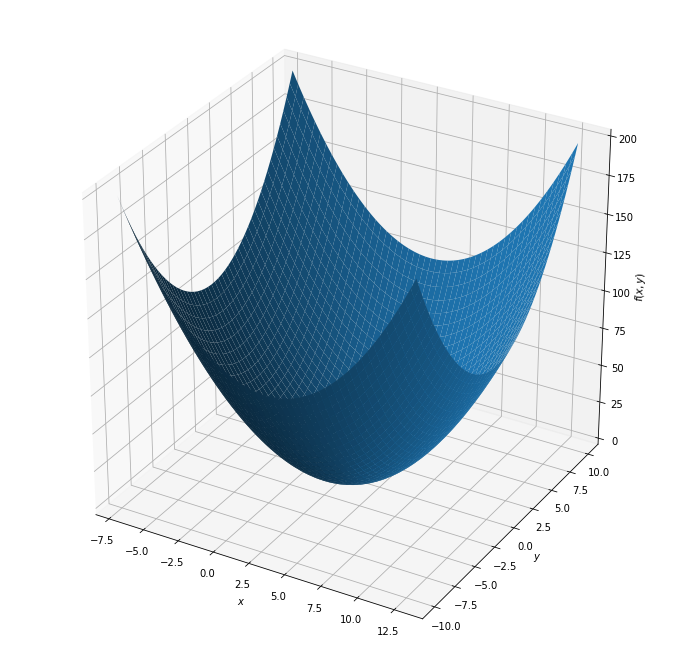

min = (2.9999999999999645, 1.4210854715202004e-13)


In [ ]:
def to_step_arg(f, x, x_prime, lmd):
    args = []
    dim = len(x)
    for i in range(dim):
        args.append(x[i] - lmd * x_prime[i](*x))
    return f(*args)

def get_symbol(dim):
    return list(map(Symbol, {
                1: ['x'],
                2: ['x', 'y'],
                3: ['x', 'y', 'z']
            }.get(dim, ['x' + str(i) for i in range(1, dim + 1)])))

def gradient_descent(f, *x, eps, max_iter_num, step_f):
    dim = len(x)
    symbol = get_symbol(dim)

    x_prime = [lambdify(symbol, f(*symbol).diff(smb)) for smb in symbol]

    x_cur = [*x]
    xs = [x_cur]
    iter_num = 0
    while True:
        if step_f is line_search:
            step = step_f(f, np.array(x_cur), x_prime)
        else:
            step = step_f(lambda lmd: to_step_arg(f, x_cur, x_prime, lmd))

        x_next = [0] * dim
        for i in range(dim):
            x_next[i] = x_cur[i] - step * x_prime[i](*x_cur)
        xs.append(x_next)

        if abs(f(*x_next) - f(*x_cur)) < eps or iter_num == max_iter_num:
            return np.array(xs), iter_num

        x_cur = x_next.copy()
        iter_num += 1

# #%%

#### 2.2 Тестируемая функция и действительное значение минимума:

# #%%

def paraboloid(x, y):
    return (x - 3) ** 2 + y ** 2


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
x = np.arange(-7.0, 13.0, 0.05)
y = np.arange(-10.0, 10.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = paraboloid(X, Y)

ax.plot_surface(X, Y, zs)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$f(x, y)$')

plt.show()

y_min_idx, x_min_idx = np.unravel_index(zs.argmin(), zs.shape)
min_p = (x[x_min_idx], y[y_min_idx])

print(f'min = {min_p}')

# #%%

#### 2.3 Графики количества итераций в зависимости от метода одномерной минимизации:

# #%%

a0, b0 = begin, end
eps = 1e-3
max_iter_num = 100


def to_step_f(one_dimensional_method, f):
    a, _, _ = one_dimensional_method(f, a0, b0, 1e-5, 100)
    return a[-1]


methods = one_dimensional_methods + [line_search]
methods_range = np.arange(len(methods))
methods_names = list(map(to_name, methods))
x0 = -112314134
y0 = 112341234

iter_nums = []

n_checks = 25

for method in methods:
    all_iters = 0
    for _ in range(n_checks):
        step_f = partial(to_step_f, odm) if method != line_search else method
        _, iter_num = gradient_descent(paraboloid, x0 * np.sqrt(all_iters), y0 * np.sqrt(all_iters), eps=eps, max_iter_num=max_iter_num, step_f=step_f)
        all_iters += iter_num
        
    iter_nums.append(all_iters / n_checks)
    
plt.bar(methods_range, iter_nums)
plt.xticks(methods_range, methods_names)
plt.ylabel('Iterations')
plt.title(to_name(gradient_descent))
plt.show()

### 3. Получите формулы для градиента и гессиана функции логистической регрессии. Выпишите их в отчет в матрично-векторной форме (без явных суммирований). Также выпишите в отчет выражение для самой функции логистической регрессии в матрично-векторной форме.
"""Функция логистической регрессии:

$$
Q(w) = \displaystyle \sum_i ln(1 + e^{-y_i(x_i w)}) + {\lambda \over 2} w^T w\\
= \displaystyle \sum_i y_i ln(1 + e^{-x_i w}) + (1 - y_i) ln(1 + e^{x_i w}) + {\lambda \over 2} w^T w\\
= [1_n\ 1 - y]
\begin{bmatrix}
ln(1 + e^{-X w}) \\
ln(1 + e^{X w})
\end{bmatrix}
+ {\lambda \over 2} w^T w
$$

Градиент:
$$
\nabla_w Q(w) = - \displaystyle \sum_i (1 - \sigma(y_i(x_i w))) + \lambda w\\
= Tr(1 - \sigma(y X w)) + \lambda w
$$

Гессиан:

$$
H = {\partial^2 Q(w) \over \partial w \partial w^T}\\
= \displaystyle \sum_i \sigma(x_i w)(1 - \sigma(x_i w))x_i x_i^T + \lambda I\\
= XAX^T + \lambda I,
$$
где $a_{ii} = \sigma(x_i w)(1 - \sigma(x_i w))$
"""

### 4. Реализуйте саму логистическую регрессию.

#### 4.1 Реализация логистической регрессии с применением градиентного спуска:

In [ ]:
def logistic_q(X, y, lmd, w):
    w_range = range(len(w))
    objects_num = X.shape[0]

    alpha = 0
    for i in range(objects_num):
        y_cur = y[i]

        sum_ = 0
        for j in w_range:
            x_cur = X[i][j]
            w_cur = w[j]
            sum_ += x_cur * w_cur

        alpha += np.logaddexp(0, -y_cur * sum_)

    sum_ = 0
    for i in w_range:
        sum_ += w[i] ** 2
    reg = lmd * sum_ / 2

    return alpha + reg


def construct_f(X, y, lmd, w, h):
    w_range = range(len(w))
    arg = w.copy()
    objects_num, _ = X.shape

    for i in range(objects_num):
        y_cur = y[i]

        sum_ = 0
        for j in w_range:
            x_cur = X[i][j]
            w_cur = w[j]
            sum_ += x_cur * w_cur

        alpha = expit(-y_cur * sum_)
        for j in w_range:
            x_cur = X[i][j]
            w_cur = w[j]
            arg[j] -= h * (lmd * w_cur + (y_cur * x_cur * w_cur) * (alpha - 1))

    return logistic_q(X, y, lmd, arg)


def logistic_gradient(X, y, lmd, w_begin, eps, max_iter_num):
    objects_num, features_num = X.shape
    w_cur = w_begin
    iter_num = 1

    while True:
        f = partial(construct_f, X, y, lmd, w_cur)
        a0, b0 = straight(f)
        a, _, _ = dichotomy(f, a0, b0, 0.01, 100)
        h = a[-1]

        w_next = w_cur.copy()

        for i in range(objects_num):
            y_cur = y[i]
            sum_ = 0
            for j in range(features_num):
                x_cur = X[i][j]
                w_cur_ = w_cur[j]
                sum_ += x_cur * w_cur_
            alpha = expit(-y_cur * sum_)
            for j in range(features_num):
                x_cur = X[i][j]
                w_cur_ = w_cur[j]
                w_next[j] -= h * (lmd * w_cur_ + (y_cur * x_cur * w_cur_) * (alpha - 1))

        if abs(logistic_q(X, y, lmd, w_next) - logistic_q(X, y, lmd, w_cur)) < eps or iter_num == max_iter_num:
            return w_next

        w_cur = w_next.copy()
        iter_num += 1


def get_classifier(w, dec_lim):
    def predict(x):
        sum_ = -dec_lim
        for i in range(len(w)):
            sum_ += w[i] * x[i]
        return 1 if sum_ > 0 else 0

    return predict

#### 4.2 Тестирование на наборе данных *Breast cancer*:

In [ ]:
def det_train_test_split(X, y, test_part):
    objects_num = X.shape[0]
    test_part = 0.3
    train_part = 1 - test_part
    train_size = int(test_part * objects_num)
    X_train, X_test, y_train, y_test = [], [], [], []
    for i in range(train_size):
        X_train.append(X[i])
        y_train.append(y[i])
    for i in range(train_size, objects_num):
        X_test.append(X[i])
        y_test.append(y[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    return X_train, X_test, y_train, y_test


def calc_score(X_train, X_test, y_train, y_test, lmd, w_begin, eps, max_iter_num, logistic_method, dec_lim_method):
    w = logistic_method(X_train, y_train, lmd, w_begin, eps, max_iter_num)
    dec_lim = dec_lim_method(X_train, w)
    classifier = get_classifier(w, dec_lim)

    test_objects_num = X_test.shape[0]
    conf_matrix = [[0] * 2 for _ in range(2)]
    for i in range(test_objects_num):
        y_real = y_test[i]
        y_pred = classifier(X_test[i])
        conf_matrix[y_pred][y_real] += 1

    tp, fp, fn, tn = conf_matrix[0][0], conf_matrix[0][1], conf_matrix[1][0], conf_matrix[1][1]
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn)
    f_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    return conf_matrix, accuracy, precision, recall, f_score


def print_score(title, conf_matrix, accuracy, precision, recall, f_score):
    if title is not None:
        print(title)
    print('Confusion matrix')
    print(pd.DataFrame(conf_matrix))
    print('Accuracy: {}'.format(accuracy))
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F-score: {}'.format(f_score))


def dec_lim_mean(X_train, w):
    train_objects_num, _ = X_train.shape
    sum_ = 0
    for i in range(train_objects_num):
        for j in range(len(w)):
            sum_ += w[j] * X_train[i][j]
    dec_lim = sum_ / train_objects_num
    return dec_lim


lgs_X, lgs_y = datasets.load_breast_cancer(return_X_y=True)
lgs_X_train, lgs_X_test, lgs_y_train, lgs_y_test = det_train_test_split(lgs_X, lgs_y, 0.3)
lgs_lmd = 1e-2
lgs_w_begin = [
    -0.00017546, -0.00701235, 0.00737026, -0.005251, -0.00884388, -0.01521721,
    0.00714003, -0.01315466, -0.00755301, 0.00589339, 0.00822666, -0.00387729,
    0.00922983, 0.00066522, 0.01494301, 0.01284885, -0.0039456, 0.00708928,
    0.00065247, -0.01562194, -0.00127419, -0.01482304, 0.01539881, 0.01018855,
    -0.00404309, 0.00450084, -0.00044222, -0.00451975, -0.00546663, -0.00670873
]
lgs_eps = 1e-2
lgs_max_iter_num = 10

calc_score_applied = partial(calc_score, lgs_X_train, lgs_X_test, lgs_y_train, lgs_y_test, lgs_lmd, lgs_w_begin, lgs_eps, lgs_max_iter_num)
grd_conf_matrix, grd_accuracy, grd_precision, grd_recall, grd_f_score = calc_score_applied(logistic_gradient, dec_lim_mean)
print_score(None, grd_conf_matrix, grd_accuracy, grd_precision, grd_recall, grd_f_score)

### 5. Реализуйте метод Ньютона.

#### 5.1 Реализация метода Ньютона:

In [ ]:
def newton_descent(f, *x, eps, max_iter_num):
    dim = len(x)
    symbol = get_symbol(dim)
    
    x_prime = [lambdify(symbol, f(*symbol).diff(smb)) for smb in symbol]
    x_y_prime = [[] for _ in range(dim)]
    for i in range(dim):
        for smb in symbol:
            x_y_prime[i].append(lambdify(symbol, x_prime[i](*symbol).diff(smb)))

    x_cur = [arg for arg in x]
    iter_num = 0
    while True:
        step = 1  # Constant step

        A = [[0 for _ in range(dim)] for _ in range(dim)]
        for i in range(dim):
            for j in range(dim):
                A[i][j] = x_y_prime[i][j](*x_cur)

        b = [0 for _ in range(dim)]
        for i in range(dim):
            b[i] = x_prime[i](*x_cur)

        c, low = cho_factor(A)
        d = cho_solve((c, low), b)

        x_next = [0] * dim
        for i in range(dim):
            x_next[i] = x_cur[i] - step * d[i]

        if abs(f(*x_next) - f(*x_cur)) < eps or iter_num == max_iter_num:
            return x_next, iter_num

        x_cur = x_next.copy()
        iter_num += 1

#### 5.2 Тестируемая функция из пункта **2.2**. Точка минимума функции согласно методу Ньютона:

In [ ]:
x0 = -112314134000
y0 = 11234123400000
min_v, iter_num = newton_descent(paraboloid, x0, y0, eps=eps, max_iter_num=max_iter_num)

print('x_min = {}'.format(min_v[0]))
print('y_min = {}'.format(min_v[1]))
print('iter_num = {}'.format(iter_num))

### 6. Проанализируйте траекторию градиентного спуска для нескольких квадратичных функций: придумайте две-три квадратичные двумерные функции, на которых работа метода будет отличаться, нарисуйте графики с линиями уровня функций и траекториями методов. Попробуйте ответить на следующий вопрос: Как отличается поведение метода в зависимости от числа обусловленности функции, выбора начальной точки и стратегии выбора шага (константная стратегия, Армихо)?

In [ ]:
def rosenbrock(x, y):
    return 100 * ((y - x ** 2) ** 2) + ((1 - x) ** 2)

In [ ]:
def draw_contour(func):
    bds_x = [-12, 12]
    bds_y = [-5, 15]
    
    nx = np.linspace(*bds_x, 500)
    ny = np.linspace(*bds_y, 500)

    xs, ys = np.meshgrid(nx, ny)

    zs = func(xs, ys)

    plt.subplots(figsize=(12, 21))
    plt.contour(xs, ys, zs, levels=500, alpha=0.5, cmap='summer')

    y_min_idx, x_min_idx = np.unravel_index(zs.argmin(), zs.shape)
    min_p = (nx[x_min_idx], ny[y_min_idx])
    plt.plot(min_p[0], min_p[1], 'o')
    plt.annotate('min', min_p)

    x0, y0 = [2, 5, 8, 11], [3, 5, 7, 9]
    
    for i, method in enumerate(methods):
        step_f = partial(to_step_f, odm) if method != line_search else method
        grad_pts, iter_num = gradient_descent(func, x0[i], y0[i], eps=1e-5, max_iter_num=50, step_f=step_f)
        x_grads, y_grads = grad_pts.T
        name = to_name(method)
        plt.plot(x_grads, y_grads, label=name)
        print(f"found min={grad_pts[-1]} by {name}, iterations={iter_num}")

    plt.axis(bds_x + bds_y)
    
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(f"{to_name(func)} contour with gradient steps")
    plt.legend()
    plt.show()

    print(f'real min={min_p}')

In [ ]:
draw_contour(rosenbrock)

In [ ]:
draw_contour(paraboloid)

### 7. Исследуйте, как зависит число итераций, необходимое градиентному спуску для сходимости, от следующих двух параметров:
$\quad$(a) числа обусловленности $k \ge 1$ оптимизируемой функции\
$\quad$(b) размерности пространства $n$ оптимизируемых переменных.

#### Для этого для заданных параметров $n$ и $k$ сгенерируйте случайным образом квадратичную задачу размера $n$ с числом обусловленности $k$ и запустите на ней градиентный спуск с некоторой фиксированной требуемой точностью. Замерьте число итераций $T(n, k)$, которое потребовалось сделать методу до сходимости (успешному выходу по критерию остановки).

In [ ]:
def create_matrix(condition_number, n):
    r = sqrt(condition_number)
    A = np.random.randn(n, n)
    u, s, v = np.linalg.svd(A)
    h, l = np.max(s), np.min(s)
    
    def f(x):
        return h * (1 - ((r - 1) / r) / (h - l) * (h - x))

    new_s = f(s)
    new_A = (u * new_s) @ v.T
    new_A = new_A @ new_A.T
    
    return new_A


def number_of_iters(cond, n_vars, step_chooser=dichotomy, n_checks=10):
    all_iters = 0
    for _ in range(n_checks):
        A = create_matrix(cond, n_vars)
        b = np.random.randn(n_vars)
        init_x = np.random.randn(n_vars)
        
        def func(*args):
            x = np.array(args)
            return x.dot(A).dot(x) - b.dot(x)

        _, iter_num = gradient_descent(func, *init_x, eps=1e-3, max_iter_num=20, step_f=partial(to_step_f, step_chooser))

        all_iters += iter_num
    return all_iters / n_checks

In [ ]:
def draw_condition():
    n_vars = list(range(2, 6))
    condition_numbers = np.linspace(1, 10, 5)
    plt.figure()
    for n in n_vars:
        iter_numbers = [number_of_iters(cond, n) for cond in condition_numbers]
        plt.plot(condition_numbers, iter_numbers, label=f'n={n}')

    plt.xlabel('$\mu$')
    plt.ylabel('$T(n, k)$')
    plt.legend()
    plt.show()

In [ ]:
draw_condition()

### 8. Сравните методы градиентного спуска и Ньютона на задаче обучения логистической регрессии.

#### 8.1 Реализация логистической регрессии с применением метода Ньютона:

In [ ]:
def logistic_newton(X, y, lmd, w_begin, eps, max_iter_num):
    objects_num, features_num = X.shape
    w_cur = w_begin
    iter_num = 1
    dim = len(w_cur)

    while True:
        h = 1  # Constant step

        grad = [0] * dim
        hessian = [[0] * dim for _ in range(dim)]
        for i in range(objects_num):
            y_cur = y[i]
            sum_ = 0
            for j in range(dim):
                x_cur = X[i][j]
                w_cur_ = w_cur[j]
                sum_ += x_cur * w_cur_
            alpha = expit(-y_cur * sum_)
            for j in range(dim):
                x_cur = X[i][j]
                w_cur_ = w_cur[j]
                grad[j] = lmd * w_cur_ + (y_cur * x_cur * w_cur_) * (alpha - 1)
                for k in range(dim):
                    if j == k:
                        hessian[j][k] = lmd + y_cur * x_cur * (alpha - 1) + (y_cur ** 2) * (x_cur ** 2) * (w_cur_ ** 2) * (1 - alpha) * alpha
                    else:
                        x_k = X[i][k]
                        w_k = w_cur[k]
                        hessian[j][k] = (y_cur ** 2) * x_cur * w_cur_ * x_k * w_k * (1 - alpha) * alpha
        
        
        grad = np.array(grad)
        hessian = np.array(hessian)
        arg = (np.linalg.inv(hessian) @ grad).T

        w_next = w_cur.copy()
        for i in range(dim):
            w_next[i] -= arg[i]

        if abs(logistic_q(X, y, lmd, w_next) - logistic_q(X, y, lmd, w_cur)) < eps or iter_num == max_iter_num:
            res = abs(logistic_q(X, y, lmd, w_next) - logistic_q(X, y, lmd, w_cur))
            # print(res)
            # print(iter_num)
            return w_next

        w_cur = w_next.copy()
        iter_num += 1

#### 8.2 Тестирование на наборе данных из пункта **4.2** и сравнение с реализацией, использующей градиентный спуск:

In [ ]:
print_score('Logistic (Gradient descent)', grd_conf_matrix, grd_accuracy, grd_precision, grd_recall, grd_f_score)

def dec_lim_f(X_train, w):
    train_objects_num, _ = X_train.shape
    sum_ = 0
    for i in range(train_objects_num):
        for j in range(len(w)):
            sum_ += w[j] * X_train[i][j]
    dec_lim = sum_ / train_objects_num
    return dec_lim

nwt_conf_matrix, nwt_accuracy, nwt_precision, nwt_recall, nwt_f_score = calc_score_applied(logistic_newton, dec_lim_f)
print()
print_score('Logistic (Newton\'s method)', nwt_conf_matrix, nwt_accuracy, nwt_precision, nwt_recall, nwt_f_score)